# Caml API Usage

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

datasets = [
    "partially_linear_simple",
    "fully_heterogenous",
    "partially_linear_constant",
    "dowhy_linear",
]
backends = ["pandas", "pyspark", "polars"]

df_backend = backends[0]
dataset = datasets[3]

## Synthetic Data

In [3]:
from caml.extensions.synthetic_data import (
    make_partially_linear_dataset_simple,
    make_fully_heterogeneous_dataset,
    make_partially_linear_dataset_constant,
    make_dowhy_linear_dataset,
)

if dataset == "partially_linear_simple":
    df, true_cates, true_ate = make_partially_linear_dataset_simple(
        n_obs=5000,
        n_confounders=5,
        dim_heterogeneity=2,
        binary_treatment=True,
        seed=None,
    )
    df["true_cates"] = true_cates
elif dataset == "fully_heterogenous":
    df, true_cates, true_ate = make_fully_heterogeneous_dataset(
        n_obs=10_000,
        n_confounders=10,
        theta=4.0,
        seed=None,
    )
    df["true_cates"] = true_cates
elif dataset == "partially_linear_constant":
    df, true_cates, true_ate = make_partially_linear_dataset_constant(
        n_obs=5000,
        ate=4.0,
        n_confounders=5,
        dgp="make_plr_CCDDHNR2018",  # make_plr_turrell2018
        seed=None,
    )
    df["true_cates"] = true_cates
elif dataset == "dowhy_linear":
    df, true_cates, true_ate = make_dowhy_linear_dataset(
        beta=2.0,
        n_obs=10_000,
        n_confounders=10,
        n_discrete_confounders=3,
        n_effect_modifiers=10,
        n_discrete_effect_modifiers=3,
        n_treatments=1,
        binary_treatment=True,
        categorical_treatment=False,
        binary_outcome=False,
        seed=12,
    )

    for i in range(1, len(true_cates) + 1):
        if isinstance(true_cates[f"d{i}"], list):
            df[f"true_cate_d{i}_1"] = true_cates[f"d{i}"][0]
            df[f"true_cate_d{i}_2"] = true_cates[f"d{i}"][1]
        else:
            df[f"true_cate_d{i}"] = true_cates[f"d{i}"]


df["uuid"] = df.index

In [4]:
try:
    import polars as pl
    from pyspark.sql import SparkSession
except ImportError:
    pass

if df_backend == "polars":
    df = pl.from_pandas(df)
    spark = None
elif df_backend == "pandas":
    spark = None
    pass
elif df_backend == "pyspark":
    spark = (
        SparkSession.builder.master("local[1]")
        .appName("local-tests")
        .config("spark.executor.cores", "1")
        .config("spark.executor.instances", "1")
        .config("spark.sql.shuffle.partitions", "1")
        .getOrCreate()
    )
    df = spark.createDataFrame(df)

In [5]:
df

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,W4,W5,W6,W7,W8,W9,d1,y,true_cate_d1,uuid
0,0.860128,1.263800,-1.621480,-1.243014,0.119318,0.138299,-2.190976,3,0,2,...,-1.777832,3.709313,0.203607,2,3,0,True,4.197980,0.793035,0
1,0.085828,-0.258028,0.648743,-1.045765,-0.128647,0.435518,0.108749,3,0,2,...,-2.000380,2.047290,1.303302,2,2,2,True,8.774372,5.340261,1
2,1.077397,-0.389245,0.503995,-1.182757,-1.419884,1.466198,-1.111965,3,3,2,...,-3.189385,0.190063,0.273025,1,2,1,False,-6.610495,7.983276,2
3,1.864333,0.424140,0.705238,1.087511,-0.978616,1.553906,-1.056368,1,3,0,...,-0.935434,0.159549,0.229549,1,3,2,True,8.211690,10.040109,3
4,0.042030,-2.178140,0.773407,-1.260931,0.600929,0.659652,-0.311650,0,3,0,...,-4.118267,1.372630,1.033920,3,0,3,True,3.598249,4.030683,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.173214,1.718103,0.527236,-0.833312,0.857061,-0.963238,-0.802704,0,2,2,...,1.446361,0.877547,0.160547,0,1,1,True,10.896206,6.942622,9995
9996,0.916397,0.691821,0.512401,-0.098800,-0.721480,0.789828,0.042103,2,2,2,...,-1.341384,-0.574287,2.923056,2,2,1,True,10.268397,9.750975,9996
9997,3.512478,-0.894800,1.119166,-1.482994,-1.278946,-0.029847,-0.221000,3,3,2,...,-1.698003,1.961363,0.020335,2,1,2,True,11.488667,11.082038,9997
9998,0.615903,1.969203,0.407985,0.945009,0.580888,0.783290,-1.168335,1,3,2,...,-2.156037,1.078907,1.013377,2,0,3,True,12.162188,11.152002,9998


In [182]:
from caml.extensions.synthetic_data import CamlSyntheticDataGenerator

data = CamlSyntheticDataGenerator(n_obs=10_000,
                                  n_cont_outcomes=1,
                                  n_binary_outcomes=0,
                                  n_cont_treatments=0,
                                  n_binary_treatments=1,
                                  n_discrete_treatments=0,
                                  n_cont_confounders=2, 
                                  n_binary_confounders=1,
                                  n_discrete_confounders=0,
                                  n_cont_heterogeneity_covariates=2,
                                  n_binary_heterogeneity_covariates=1,
                                  n_discrete_heterogeneity_covariates=0,
                                  n_heterogeneity_confounders=0,
                                  stddev_outcome_noise=0,
                                  stddev_treatment_noise=0,
                                  causal_model_functional_form="fully_non_linear",
                                  seed=None)

synthetic_df = data.df
cate_df = data.cates
ate_df = data.ates

df = synthetic_df.copy()

df

,W1_continuous,W2_continuous,W1_binary,X1_continuous,X2_continuous,X1_binary,T1_binary,Y1_continuous
0,2.996031,1.833142,1,-2.318365,-0.889071,1,1,5.698096
1,1.084660,0.811684,0,-3.947338,-4.538094,0,1,-67.510466
2,1.551872,3.514753,1,-2.712781,-4.356513,0,1,-46.807338
3,1.488719,1.312660,1,-5.847153,-2.044083,0,1,-3.311405
4,3.932037,3.688375,1,-3.001796,-3.986808,0,1,-37.739799
...,...,...,...,...,...,...,...,...
9995,1.168482,7.503267,0,-4.596117,-2.361790,0,1,94.887914
9996,4.346783,1.878845,1,-5.297084,-3.215238,0,1,-30.937156
9997,0.889781,0.231083,1,-5.627272,-2.961529,0,1,-22.289016
9998,3.790647,0.399154,0,-2.683229,-1.265921,0,0,3.198673


In [183]:
cate_df

,CATE_of_T1_binary_on_Y1_continuous
0,-7.257272
1,-17.647557
2,-17.130521
3,-10.546072
4,-16.077816
...,...
9995,-11.450715
9996,-13.880836
9997,-13.158422
9998,-8.330320


In [184]:
ate_df

,Treatment,ATE
0,T1_binary_on_Y1_continuous,-13.5267


## Core API

### CamlCATE

#### Class Instantiation

In [185]:
from caml import CamlCATE

caml = CamlCATE(
    df=df,
    Y="Y1_continuous",
    T="T1_binary",
    X=[c for c in df.columns if "X" in c or "W" in c],
    W=[],
    discrete_treatment=True,
    discrete_outcome=False,
    seed=10,
    verbose=1,
)

[12/15/24 19:53:51] INFO     Logging has been set up.                                                 ]8;id=564215;file:///home/jakep/projects/caml/caml/logging.py\logging.py]8;;\:]8;id=63563;file:///home/jakep/projects/caml/caml/logging.py#51\51]8;;\

In [145]:
print(caml)

================== CamlCATE Object ==================
Data Backend: pandas
No. of Observations: 10,000
Outcome Variable: Y1_continuous
Discrete Outcome: False
Treatment Variable: T1_binary
Discrete Treatment: True
Features/Confounders for Heterogeneity (X): ['W1_continuous', 'W2_continuous', 'W1_binary', 'X1_continuous', 'X2_continuous', 'X1_binary']
Features/Confounders as Controls (W): []
Random Seed: 10



#### Nuissance Function AutoML

In [186]:
caml.auto_nuisance_functions(
    flaml_Y_kwargs={"time_budget": 180,"verbose":0},
    flaml_T_kwargs={"time_budget": 180,"verbose":0},
    use_ray=False,
    use_spark=False,
)

The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.


#### Fit and ensemble CATE models

In [187]:
caml.fit_validator(
    subset_cate_models=[
        "LinearDML",
        "CausalForestDML",
        # "NonParamDML",
        # "AutoNonParamDML",
        # "SparseLinearDML-2D",
        "DRLearner",
        "ForestDRLearner",
        "LinearDRLearner",
        # "SparseLinearDRLearner-2D",
        "DomainAdaptationLearner",
        "SLearner",
        "TLearner",
        "XLearner"
    ],
    rscorer_kwargs={},
    use_ray=False,
    ray_remote_func_options_kwargs={},
    sample_fraction=1.0,
    n_jobs=-1,
)

[12/15/24 20:03:23] INFO     Ensemble Estimator RScore: 0.014050860651870445                            ]8;id=959031;file:///home/jakep/projects/caml/caml/core/cate.py\cate.py]8;;\:]8;id=842716;file:///home/jakep/projects/caml/caml/core/cate.py#734\734]8;;\

                    INFO     Inidividual Estimator RScores: {'LinearDML': 0.007861779579292794,         ]8;id=217411;file:///home/jakep/projects/caml/caml/core/cate.py\cate.py]8;;\:]8;id=277310;file:///home/jakep/projects/caml/caml/core/cate.py#735\735]8;;\
                             'CausalForestDML': -0.031287339855830876, 'DRLearner':                                
                             -0.2867862880778751, 'ForestDRLearner': 0.006294303165402804,                         
                             'LinearDRLearner': 0.002985282784290999, 'DomainAdaptationLearner':                   
                             0.01303776325186179, 'SLearner': 0.009069942656652952, 'TLearner':                    
                             0.014082149259115773, 'XLearner': 0.008804466717731607}                               

                    INFO     The best estimator is greater than the ensemble estimator. Returning that  ]8;id=447966;file:///home/jakep/projects/caml/caml/core/cate.py\cate.py]8;;\:]8;id=761557;file:///home/jakep/projects/caml/caml/core/cate.py#747\747]8;;\
                             individual estimator: <econml.metalearners._metalearners.TLearner object              
                             at 0x7f15330d6aa0>                                                                    

In [188]:
caml.validation_estimator

                    INFO     The validation estimator has been fit and will be returned.                ]8;id=535081;file:///home/jakep/projects/caml/caml/core/_base.py\_base.py]8;;\:]8;id=734490;file:///home/jakep/projects/caml/caml/core/_base.py#61\61]8;;\

#### CATE Validation

[12/15/24 20:03:30] INFO     All validation results suggest that the model has found statistically      ]8;id=282064;file:///home/jakep/projects/caml/caml/core/cate.py\cate.py]8;;\:]8;id=595059;file:///home/jakep/projects/caml/caml/core/cate.py#472\472]8;;\
                             significant heterogeneity.                                                            

   treatment  blp_est  blp_se  blp_pval  qini_est  qini_se  qini_pval  autoc_est  autoc_se  autoc_pval  cal_r_squared
0          1    1.013   0.005       0.0     6.543    0.365        0.0     26.061     1.766         0.0          0.967


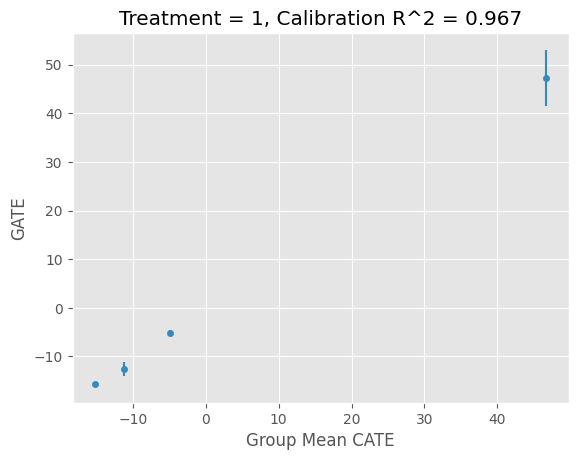

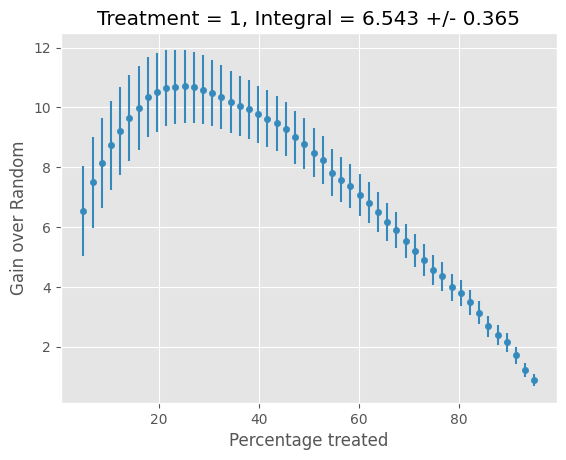

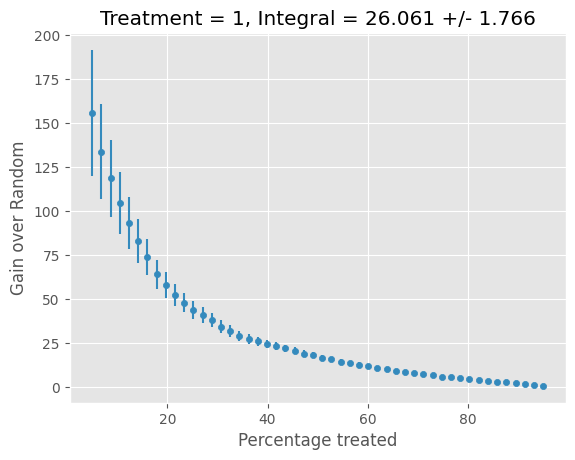

In [189]:
validation_results = caml.validate(n_groups=4,n_bootstrap=100,print_full_report=True)

#### Refit best estimator on full dataset

In [190]:
caml.fit_final()

In [191]:
caml.final_estimator

[12/15/24 20:03:31] INFO     The final estimator has been fit on the entire dataset and will be         ]8;id=118645;file:///home/jakep/projects/caml/caml/core/_base.py\_base.py]8;;\:]8;id=683356;file:///home/jakep/projects/caml/caml/core/_base.py#71\71]8;;\
                             returned.                                                                             

#### Predict CATEs

In [192]:
## "Out of sample" predictions

cate_predictions = caml.predict(T0=0,T1=1)

cate_predictions

array([ -3.83832344, -16.82219892,  -0.82421607, ..., -13.28251633,
        -6.43660927,  -1.72116209])

#### CATE Visualization/Summary

In [193]:
cate_summary = caml.summarize()

cate_summary

,cate_predictions_0_1
count,10000.000000
mean,4.899102
std,42.371674
min,-38.223703
25%,-12.925362
50%,-9.149481
75%,2.274296
max,722.867222


In [194]:
ate_df

,Treatment,ATE
0,T1_binary_on_Y1_continuous,-13.5267


#### Access my dataframe, estimator object, and get string representation of class

In [195]:
caml.df

,W1_continuous,W2_continuous,W1_binary,X1_continuous,X2_continuous,X1_binary,T1_binary,Y1_continuous
0,2.996031,1.833142,1,-2.318365,-0.889071,1,1,5.698096
1,1.084660,0.811684,0,-3.947338,-4.538094,0,1,-67.510466
2,1.551872,3.514753,1,-2.712781,-4.356513,0,1,-46.807338
3,1.488719,1.312660,1,-5.847153,-2.044083,0,1,-3.311405
4,3.932037,3.688375,1,-3.001796,-3.986808,0,1,-37.739799
...,...,...,...,...,...,...,...,...
9995,1.168482,7.503267,0,-4.596117,-2.361790,0,1,94.887914
9996,4.346783,1.878845,1,-5.297084,-3.215238,0,1,-30.937156
9997,0.889781,0.231083,1,-5.627272,-2.961529,0,1,-22.289016
9998,3.790647,0.399154,0,-2.683229,-1.265921,0,0,3.198673


In [196]:
from econml.score import EnsembleCateEstimator

# Use this estimator object as pickled object for optimized inference
final_estimator = caml.final_estimator

if isinstance(final_estimator, EnsembleCateEstimator):
    for mod in final_estimator._cate_models:
        print(mod)
        print(mod._input_names)
else:
    print(final_estimator)
    print(final_estimator._input_names)

                    INFO     The final estimator has been fit on the entire dataset and will be         ]8;id=877588;file:///home/jakep/projects/caml/caml/core/_base.py\_base.py]8;;\:]8;id=1747;file:///home/jakep/projects/caml/caml/core/_base.py#71\71]8;;\
                             returned.                                                                             

{'feature_names': ['W1_continuous', 'W2_continuous', 'W1_binary', 'X1_continuous', 'X2_continuous', 'X1_binary'], 'output_names': 'Y1_continuous', 'treatment_names': 'T1_binary'}


In [197]:
print(caml)

================== CamlCATE Object ==================
Data Backend: pandas
No. of Observations: 10,000
Outcome Variable: Y1_continuous
Discrete Outcome: False
Treatment Variable: T1_binary
Discrete Treatment: True
Features/Confounders for Heterogeneity (X): ['W1_continuous', 'W2_continuous', 'W1_binary', 'X1_continuous', 'X2_continuous', 'X1_binary']
Features/Confounders as Controls (W): []
Random Seed: 10
Nuissance Model Y_X: ExtraTreesRegressor(max_features=0.8442539949256324, max_leaf_nodes=3642,
                    n_estimators=95, n_jobs=-1, random_state=12032022)
Propensity/Nuissance Model T_X: XGBClassifier(base_score=None, booster=None, callbacks=[],
              colsample_bylevel=1.0, colsample_bynode=None,
              colsample_bytree=0.9090904131765215, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interacti

In [198]:
df

,W1_continuous,W2_continuous,W1_binary,X1_continuous,X2_continuous,X1_binary,T1_binary,Y1_continuous
0,2.996031,1.833142,1,-2.318365,-0.889071,1,1,5.698096
1,1.084660,0.811684,0,-3.947338,-4.538094,0,1,-67.510466
2,1.551872,3.514753,1,-2.712781,-4.356513,0,1,-46.807338
3,1.488719,1.312660,1,-5.847153,-2.044083,0,1,-3.311405
4,3.932037,3.688375,1,-3.001796,-3.986808,0,1,-37.739799
...,...,...,...,...,...,...,...,...
9995,1.168482,7.503267,0,-4.596117,-2.361790,0,1,94.887914
9996,4.346783,1.878845,1,-5.297084,-3.215238,0,1,-30.937156
9997,0.889781,0.231083,1,-5.627272,-2.961529,0,1,-22.289016
9998,3.790647,0.399154,0,-2.683229,-1.265921,0,0,3.198673


# Plots

In [199]:
cate_df

,CATE_of_T1_binary_on_Y1_continuous
0,-7.257272
1,-17.647557
2,-17.130521
3,-10.546072
4,-16.077816
...,...
9995,-11.450715
9996,-13.880836
9997,-13.158422
9998,-8.330320


In [200]:
from caml.extensions.plots import (cate_histogram_plot, 
                                   cate_true_vs_estimated_plot, 
                                   cate_line_plot)

df['cate_predictions'] = cate_predictions
df['true_cates'] = cate_df.iloc[:,0]

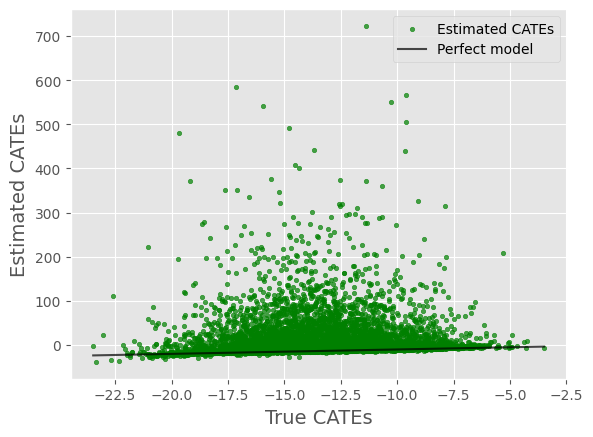

In [201]:
cate_true_vs_estimated_plot(true_cates=df['true_cates'],estimated_cates=df['cate_predictions'])

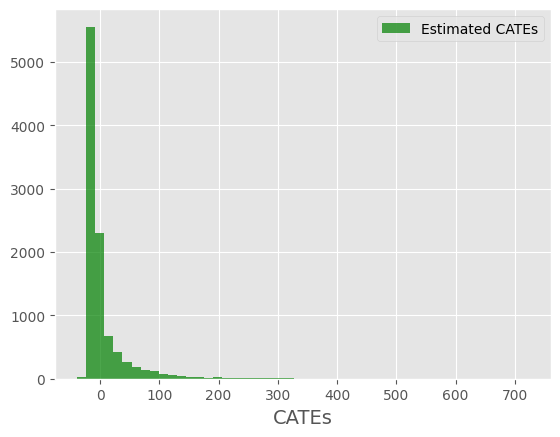

In [202]:
cate_histogram_plot(estimated_cates=df['cate_predictions'])

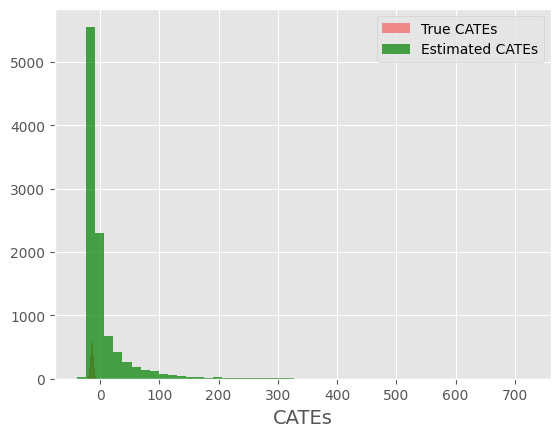

In [203]:
cate_histogram_plot(estimated_cates=df['cate_predictions'],true_cates=df['true_cates'])

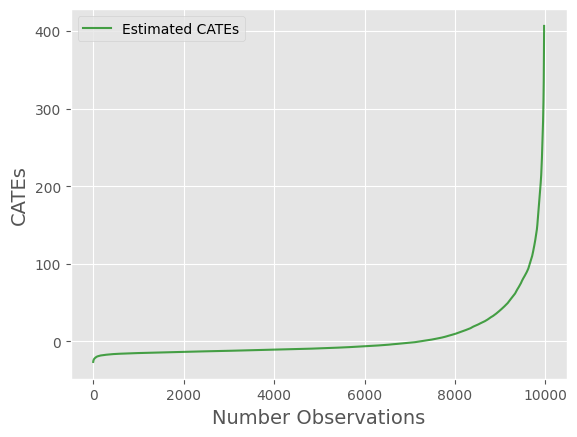

In [204]:
cate_line_plot(estimated_cates=df['cate_predictions'],window=30)

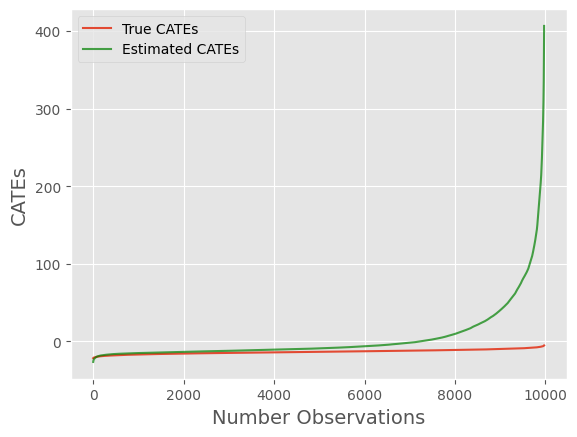

In [205]:
cate_line_plot(estimated_cates=df['cate_predictions'],true_cates=df['true_cates'],window=30)